In [51]:
#from PyQt5.QtWidgets import *
#from PyQt5.QtGui import *
#from PyQt5.QtCore import Qt
import os
from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget
import dsp_lib

In [52]:
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np
#import cmath
#import math
#from commpy.filters import rcosfilter
#from ipywidgets import interact, widgets

In [53]:
from scipy.signal import butter, filtfilt
import os
from array import array
def read_signal(file_name, data_type):
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    iq_size_in_bytes = 4
    number_of_int_to_read = file_size // iq_size_in_bytes * 2
    arr = array(data_type)
    with open(file_path, 'rb') as fileobj:
        arr.fromfile(fileobj, number_of_int_to_read)
    i = np.array(arr[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(arr[1:: 2])
    q = q.reshape((len(q), 1))
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten


def find_carr_freq(spectrum, min_sig_lvl):
    idx = list(np.where(spectrum >= min_sig_lvl))
    idx = idx[0]
    f_low = idx[0]
    f_high = idx[-1]
    carr_freq = round((f_low + f_high) / 2)
    return carr_freq


def mixing_signal(signal, freq):
    N = len(signal)
    k = freq
    n = np.arange(0, N, 1)
    mixer = np.exp(-1j * 2 * math.pi * k * n / N)
    mixed_signal = np.multiply(signal, mixer)
    return mixed_signal


def filter_signal(mixed_sig, normal_cutoff):
    order = 2
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sig_filtered = filtfilt(b, a, mixed_sig)
    return sig_filtered

In [54]:
def resampling_lagrange_step_ver(s, step, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    #if (p > 1):
    #    if (q == 1):
    #        y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
    #    else:
    #        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    #else:
    #    y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    if (step > 1):
        y = np.zeros(int((len(s) -1) / step) + 1, dtype=np.csingle)
    else:
        y = np.zeros(int(len(s) / step), dtype=np.csingle) 
    
    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    print(f"len(y) = {len(y)}, len(t) = {len(t)}, len(s) = {len(s)}")

    for k in range(len(y)):
        #x = k * q / p - x0
        x = k * step - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        #print(f"x = {x}, n = {n}, d = {d}")
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1
        #print(f"a0 = {a0} a1 = {a1} a2 = {a2} a3 = {a3}")
        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    #print(t)
    return y

In [55]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [56]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def add_freq(sig, f0_to_fsig):
    n = np.arange(0, len(sig), 1)
    mixer = np.exp(1j * np.pi * f0_to_fsig * n)
    #print(mixer[(821500 - 10 -1) : (821500 - 1)])
    return sig * mixer

In [57]:
def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RRC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf

In [58]:
def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    assert (n % 2 == 1), "RC filter length should be odd!"
    n += 1 # because first sample will be not used
    s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    return s_psf

In [59]:
def add_phase(sig, phase):
# phase = [-1, 1] [semicircles]
    sig *= np.exp(1j * np.pi * phase)
    return sig

In [60]:
def save_cmplx_sig_to_int16(signal, filename):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    arr_int16_re = s_re.astype(np.int16)
    arr_int16_im = s_im.astype(np.int16)
    arr_int = np.empty(len(two_sigs) * 2, dtype=int)
    print(len(arr_int))
    arr_int[ : : 2] = arr_int16_re
    arr_int[1 : : 2] = arr_int16_im
    saved_arr = arr_int.astype(np.int16)
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

def save_cmplx_sig(signal, filename, data_type='int16'):
    sig = np.round(signal)
    s_re = signal.real
    s_im = signal.imag
    if data_type == 'int16':
        arr_to_type_re = s_re.astype(np.int16)
        arr_to_type_im = s_im.astype(np.int16)
        arr_int = np.empty(len(signal) * 2, dtype=int)
    if data_type == 'float32':
        arr_to_type_re = s_re.astype(np.float32)
        arr_to_type_im = s_im.astype(np.float32)
        arr_int = np.empty(len(signal) * 2, dtype=float)
    if data_type == 'float64':
        arr_to_type_re = s_re.astype(np.float64)
        arr_to_type_im = s_im.astype(np.float64)
        arr_int = np.empty(len(signal) * 2, dtype=np.float64)

    print(len(arr_int))
    arr_int[ : : 2] = arr_to_type_re
    arr_int[1 : : 2] = arr_to_type_im
    if data_type == 'int16':
        saved_arr = arr_int.astype(np.int16)
    if data_type == 'float32':
        saved_arr = arr_int.astype(np.float32)
    if data_type == 'float64':
        saved_arr = arr_int.astype(np.float64)
        
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

In [61]:
def gen_qpsk_symbols(n_symb, fs):
    # create IQ of QPSK
    # complex array: [(1 + 1j, 1 -1j, ..., -1 -1j)]
    data = np.random.randint(0, 4, n_symb)
    #print(len(data))
    #x_tr = x.transpose()
    y = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
    iq = [y[val] for val in data]
    iq_ups = np.zeros(n_symb * fs, dtype=complex)
    iq_ups[:len(iq) * fs:fs] = iq
    return iq_ups

In [62]:
def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

In [63]:
# a = [7, 3, 5, 2, 1, 4, 1]
# b = [2, 3, 4, 3, 2, 1]
# conv = np.convolve(a, b, 'same')
# print(conv)

In [64]:
# N = 7
# Fs = 1
# T_symb = 8#1 / sig_board
# s_rc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
# plot_signal_power(s_rc, 0)
#
# N_symb = 2
# sps = 8 # f_sampling / f_symbol (SPS)
# s_qpsk = gen_qpsk_symbols(N_symb, sps)
# print(s_qpsk)
# plot_signal_power(s_qpsk, 1)
#
# qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')
# print(qpsk_rc)
# plot_signal_power(qpsk_rc, 2)

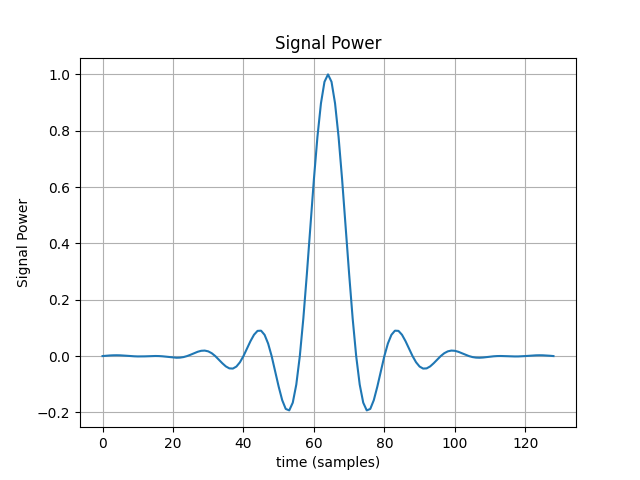

In [65]:
sig_board = 0.168
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rc = gen_rc_filter_impulse_response(N, Fs, T_symb)
plot_signal_power(s_rc, 0)


f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

N_symb = N * 1000
sps = 8 # f_sampling / f_symbol (SPS)
s_qpsk = gen_qpsk_symbols(N_symb, sps)
qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')


In [66]:
mixed_qpsk = add_freq(qpsk_rc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)

In [67]:
two_sigs = mixed_qpsk + qpsk_rc
two_sigs = upscale_to_i16(two_sigs)

(4.601461360751147-1.371893268424799j)
4.601461360751147
4.607790638867229
7111.217190209705


In [68]:
save_cmplx_sig(two_sigs, 'qpsk_rc_float32.bid')

2064000
[-17043   5537  -5243  -3874   -327   9915 -18086  11348 -18592  -8303
  -1201  -6979  -7413   7023 -19892  -4790  -5537 -17043   3920  -4245
  -7791  -2185  -3245 -16749  12935 -10872   6009   1804  -3429  -9008]


129
1
8
(4.247319398479498-1.2973294640237465j)
4.247319398479498
4.295512625770891
7628.193152876485
2064000
[-17445.56218344   8147.7308216   -5890.83372494  -3265.25363334
    723.86794084   9876.469984   -17195.95802093  12221.88925542
 -18866.46495783  -8308.53917301  -1064.98616395  -7473.72153011
  -8675.21335857   7660.96852716 -23744.33947653  -6047.92117446
  -7503.9904112  -20810.73690227   4357.73935062  -5641.5669445
  -9433.18985643  -1369.38459552  -5668.48972549 -17794.50149502
  12974.25338893 -11986.63696805   6250.68745979   2111.76207683
  -2796.88642521 -10109.48543882]


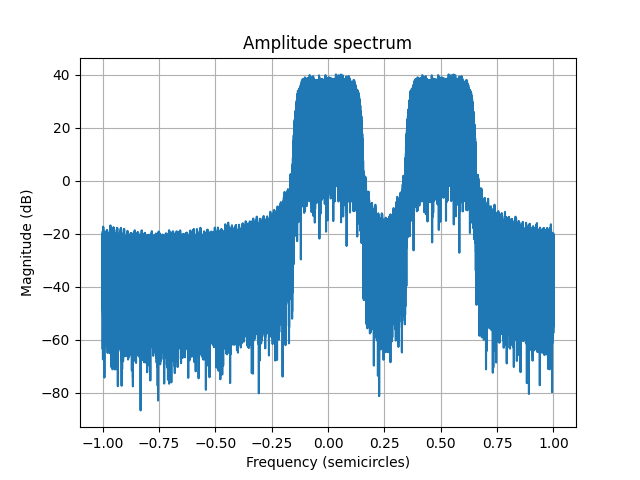

array([[-29.17792605],
       [-33.17467093],
       [-29.81961119],
       ...,
       [-34.30305442],
       [-29.7219693 ],
       [-31.02975485]])

In [69]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
max(two_sigs)
two_sigs_upsc = upscale_to_i16(two_sigs)
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float.bin', 'float64')
max(two_sigs_upsc)
plot_spectrum(two_sigs_upsc, 10)

129
1
8
(4.247319398479498-1.2973294640237465j)
4.247319398479498
4.295512625770891
7628.193152876485
sig len = 1032000
2064000
[-17445.56218344   8147.7308216   -5890.83372494  -3265.25363334
    723.86794084   9876.469984   -17195.95802093  12221.88925542
 -18866.46495783  -8308.53917301  -1064.98616395  -7473.72153011
  -8675.21335857   7660.96852716 -23744.33947653  -6047.92117446
  -7503.9904112  -20810.73690227   4357.73935062  -5641.5669445
  -9433.18985643  -1369.38459552  -5668.48972549 -17794.50149502
  12974.25338893 -11986.63696805   6250.68745979   2111.76207683
  -2796.88642521 -10109.48543882]
2064000
[-17445.562    8147.731   -5890.8335  -3265.2537    723.8679   9876.47
 -17195.959   12221.89   -18866.465   -8308.539   -1064.9862  -7473.7217
  -8675.213    7660.9688 -23744.34    -6047.9214  -7503.99   -20810.736
   4357.7393  -5641.567   -9433.189   -1369.3846  -5668.4897 -17794.502
  12974.253  -11986.637    6250.6875   2111.762   -2796.8865 -10109.485 ]


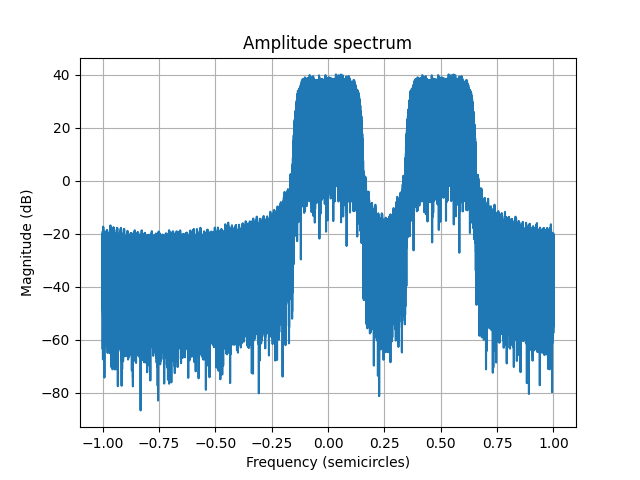

[-17445.56218344 +8147.7308216j   -5890.83372494 -3265.25363334j
    723.86794084 +9876.469984j   -17195.95802093+12221.88925542j
 -18866.46495783 -8308.53917301j  -1064.98616395 -7473.72153011j
  -8675.21335857 +7660.96852716j -23744.33947653 -6047.92117446j
  -7503.9904112 -20810.73690227j   4357.73935062 -5641.5669445j ]


In [70]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
two_sigs_upsc = upscale_to_i16(two_sigs)
print(f"sig len = {len(two_sigs_upsc)}")
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float64.bin', 'float64')
save_cmplx_sig(two_sigs_upsc, 'qpsk_rrc_float32.bin', 'float32')
max(two_sigs_upsc)
plot_spectrum(two_sigs_upsc, 10)
print(two_sigs_upsc[:10])

In [71]:
qpsk_rrc_rrc = np.convolve(two_sigs_upsc, s_rrc, 'same')
print(two_sigs_upsc[:10])
print(s_rrc)
print(qpsk_rrc_rrc[:10])
print(qpsk_rrc_rrc[len(qpsk_rrc_rrc) - 10::])
# samples_32 = dsp_lib.read_signal('qpsk_rrc_float32.bin', 'float32')
# sig32 = dsp_lib.make_cmplx_sig(samples_32)
# print(sig32[:10])

[-17445.56218344 +8147.7308216j   -5890.83372494 -3265.25363334j
    723.86794084 +9876.469984j   -17195.95802093+12221.88925542j
 -18866.46495783 -8308.53917301j  -1064.98616395 -7473.72153011j
  -8675.21335857 +7660.96852716j -23744.33947653 -6047.92117446j
  -7503.9904112 -20810.73690227j   4357.73935062 -5641.5669445j ]
[-5.27526056e-03 -3.99102742e-03 -1.64842729e-03  1.29551186e-03
  4.20829446e-03  6.41713384e-03  7.36294421e-03  6.73849224e-03
  4.57739857e-03  1.26984331e-03 -2.50378491e-03 -5.91158303e-03
 -8.15394430e-03 -8.65281056e-03 -7.20253053e-03 -4.04416717e-03
  1.59973235e-04  4.45338056e-03  7.79222114e-03  9.28996172e-03
  8.44532739e-03  5.29838667e-03  4.71398168e-04 -4.92610836e-03
 -9.51895698e-03 -1.19753744e-02 -1.13400852e-02 -7.31607595e-03
 -4.23543130e-04  8.01507220e-03  1.60811386e-02  2.16328990e-02
  2.27812262e-02  1.83734040e-02  8.37737184e-03 -5.93206756e-03
 -2.20523040e-02 -3.66153950e-02 -4.59937904e-02 -4.70527982e-02
 -3.79107833e-02 -1.8549

In [72]:
print(qpsk_rrc_rrc[:10])

[-50075.42116784+24708.35862616j -65652.79434878+22309.92245555j
 -79955.1716023 +16652.17367878j -91209.28523494 +7959.6190125j
 -97950.01166038 -3112.35455993j -99044.22467428-15829.06037004j
 -93638.21689564-29237.35872826j -81596.46397095-42115.75052012j
 -63694.12832671-53444.44906122j -41263.57847544-62581.08832304j]


[-17445.56218344 +8147.7308216j   -5890.83372494 -3265.25363334j
    723.86794084 +9876.469984j   -17195.95802093+12221.88925542j
 -18866.46495783 -8308.53917301j  -1064.98616395 -7473.72153011j
  -8675.21335857 +7660.96852716j -23744.33947653 -6047.92117446j
  -7503.9904112 -20810.73690227j   4357.73935062 -5641.5669445j ]
(120065.13706716806+51633.101557996466j)
120065.13706716806
119579.56030294044
0.27291019525234167
2064000
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


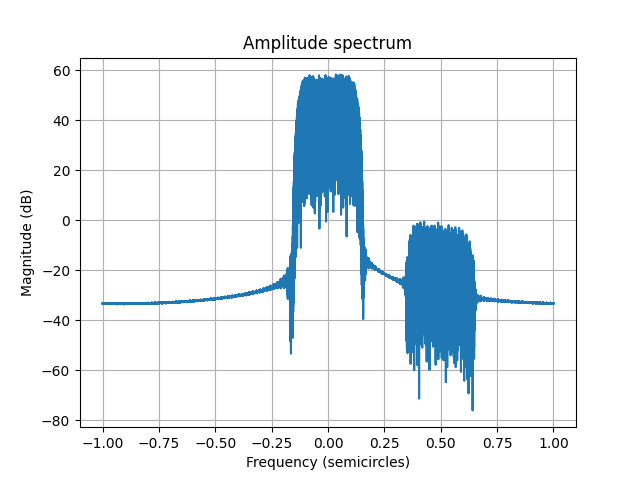

array([[-33.30859826],
       [-33.19297454],
       [-33.20041935],
       ...,
       [-33.27113368],
       [-33.2146272 ],
       [-33.18375975]])

In [73]:
qpsk_rrc_rrc = np.convolve(two_sigs_upsc, s_rrc, 'same')
print(two_sigs_upsc[:10])

two_sigs_upsc_i16 = upscale_to_i16(qpsk_rrc_rrc)
save_cmplx_sig_to_int16(two_sigs_upsc_i16, 'qpsk_rrc_rrc_int16_.bin')

plot_spectrum(qpsk_rrc_rrc, 1)


(1.95332457732921+1.2028829503220488j)
1.95332457732921
1.95332457732921
16774.98987126987


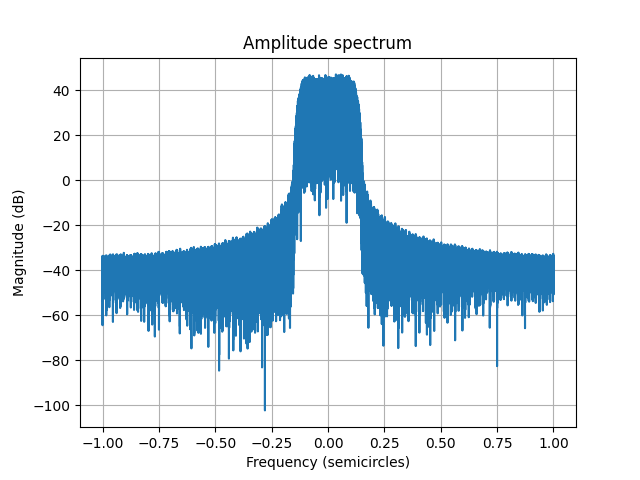

array([[-37.38994011],
       [-42.69915344],
       [-42.38340396],
       ...,
       [-38.38577203],
       [-41.53096966],
       [-41.46978543]])

In [74]:
qpsk_upsc = upscale_to_i16(qpsk_rc)
plot_spectrum(qpsk_upsc, 2)

In [75]:
save_cmplx_sig_to_int16(qpsk_upsc, 'qpsk_rc_int16_1_sig.bin')

2064000
[-16774  16774 -20247  14464 -23338  10935 -25681   6453 -26918   1379
 -26753  -3869 -25001  -8877 -21626 -13272 -16774 -16774 -10786 -19237
  -4131 -20613   2590 -20998   8723 -20597  13637 -19684  16808 -18563]
